In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd '/home/vagrawal/RVT-CO2/code'

/home/vagrawal/RVT-CO2/code


In [72]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 

import torch
from torch.utils.data import DataLoader
from models import *
from datasets import resp_co2_dataset

import utils

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [9,4]

In [5]:
%matplotlib inline
# matplotlib.style.use('seaborn')
plt.rcParams["figure.figsize"] = [15,12]
plt.rcParams.update({'font.size': 14})

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')

device = cuda


# Basic


In [73]:
baycrest_root = '/home/vagrawal/RVT-CO2/data/raw_physio_backup-biopac-20180417/preprocessed'
data_split_number = 0
txt_root = os.path.join(baycrest_root, 'splits_train_test', str(data_split_number))
apply_co2_norm = True
return_sub_name = True
save_plt_dir = '/home/vagrawal/RVT-CO2/code/saved_plots/manuscript/output_graphs'

In [74]:
dataloader_train = resp_co2_dataset(txt_root, resp_filename = 'resp_train.txt', co2_filename = 'co2_train.txt',apply_co2_norm=apply_co2_norm, return_sub_name = return_sub_name)
# dataloader_val = resp_co2_dataset(txt_root, resp_filename = 'resp_val.txt', co2_filename = 'co2_val.txt',apply_co2_norm=apply_co2_norm, return_sub_name = return_sub_name)
dataloader_test = resp_co2_dataset(txt_root, resp_filename = 'resp_test.txt', co2_filename = 'co2_test.txt',apply_co2_norm=apply_co2_norm, return_sub_name = return_sub_name)

dataloaders = {
    'train':DataLoader(dataloader_train, batch_size=1, shuffle=True),
#     'val':DataLoader(dataloader_val, batch_size=1, shuffle=True),
    'test':DataLoader(dataloader_test, batch_size=1, shuffle=False)
}

# Linear Regression without tanh

In [63]:
nnLR = linear_without_tanh(in_channels=1, out_channels=1).to(device)
checkpoint = torch.load('/home/vagrawal/RVT-CO2/code/saved_models/20201011_baycrest/linear_without_tanh/0.pth.gz')
nnLR.load_state_dict(checkpoint['model_state_dict'])

# Conv 4L with wgt loss

In [64]:
nnConv4L_wgt = conv_4_layer(in_channels=1, out_channels=1).to(device)
checkpoint = torch.load('/home/vagrawal/RVT-CO2/code/saved_models/20201011_baycrest/conv_4_layer_weightedLoss/0.pth.gz')
nnConv4L_wgt.load_state_dict(checkpoint['model_state_dict'])

23


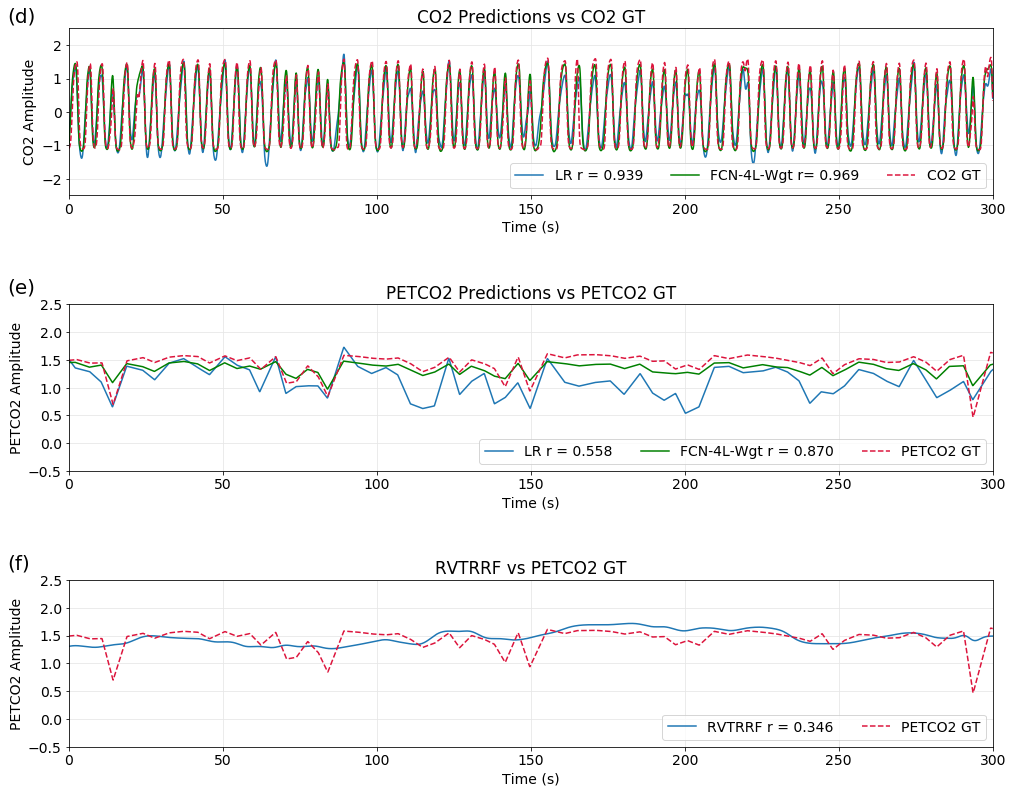

In [65]:
phase = 'test'
plots_fcn = True
plots_rvt = True
output_smoothing = True
save_figs = True

corr_stats = {}
for j, sampled_batch in enumerate(dataloaders[phase]):
    
    if j not in [23]:
        continue

    resp, co2 = sampled_batch
    resp = resp.to(device, dtype=torch.float)
    co2 = co2.to(device, dtype=torch.float)
    
    co2_pred_nnLR = nnLR(resp)
    co2_pred_nnConv4L_wgt = nnConv4L_wgt(resp)
    
    resp = np.squeeze(resp.cpu().detach().numpy())
    co2 = np.squeeze(co2.cpu().detach().numpy())
    co2_pred_nnLR = np.squeeze(co2_pred_nnLR.cpu().detach().numpy())
    co2_pred_nnConv4L_wgt = np.squeeze(co2_pred_nnConv4L_wgt.cpu().detach().numpy())
    
    if output_smoothing:
        co2_pred_nnLR = utils.moving_average(co2_pred_nnLR, w = 7, mode = 'same')
        co2_pred_nnConv4L_wgt = utils.moving_average(co2_pred_nnConv4L_wgt, w = 7, mode = 'same')

    petco2_gt = utils.get_petco2_interpolated(co2, Fs=10, len_interpolated=len(co2), thres=0.3)
    petco2_pred_nnLR = utils.get_petco2_interpolated(co2_pred_nnLR, Fs=10, len_interpolated=len(co2), thres=0.5)
    petco2_pred_nnConv4L_wgt = utils.get_petco2_interpolated(co2_pred_nnConv4L_wgt, Fs=10, len_interpolated=len(co2), thres=0.3)
        
    corr_stats['corr_co2_nnLR'] = pearsonr(co2, co2_pred_nnLR)[0]
    corr_stats['corr_co2_nnConv4L_wgt'] = pearsonr(co2, co2_pred_nnConv4L_wgt)[0]
    corr_stats['corr_petco2_nnLR'] = pearsonr(petco2_gt, petco2_pred_nnLR)[0]
    corr_stats['corr_petco2_nnConv4L_wgt'] = pearsonr(petco2_gt, petco2_pred_nnConv4L_wgt)[0]
        
    if plots_fcn:
        plt.figure()
        plt.subplot(311)
        t1 = 1000
        t2 = 4000
        x_val = np.linspace(0,(t2 -t1)/10, t2 -t1)
        plt.plot(x_val, co2_pred_nnLR[t1:t2], label = f"LR r = {corr_stats['corr_co2_nnLR']:0.3f}")
        plt.plot(x_val, co2_pred_nnConv4L_wgt[t1:t2],linestyle='-',color = 'g',label = f"FCN-4L-Wgt r= {corr_stats['corr_co2_nnConv4L_wgt']:0.3f}")
        plt.plot(x_val, co2[t1:t2], linestyle='--', label = 'CO2 GT', color='crimson')
        plt.ylabel("CO2 Amplitude")
        plt.xlabel("Time (s)")
        plt.ylim((-2.5, 2.5))
        plt.xlim((0, (t2-t1)/10))
        plt.legend(loc="lower right",  ncol=3)
        print(j)
        plt.title(f"CO2 Predictions vs CO2 GT") 
        plt.text(-20, 2.7, '(d)',size=20)
        plt.locator_params(axis='x', nbins=10)
        plt.grid(axis='y', color='0.9')
        plt.grid(axis='x', color='0.9')

        plt.subplot(312)
        plt.plot(x_val, petco2_pred_nnLR[t1:t2], label = f"LR r = {corr_stats['corr_petco2_nnLR']:0.3f}")
        plt.plot(x_val, petco2_pred_nnConv4L_wgt[t1:t2], color = 'g',label = f"FCN-4L-Wgt r = {corr_stats['corr_petco2_nnConv4L_wgt']:0.3f}")
        plt.plot(x_val, petco2_gt[t1:t2], linestyle='dashed', label = 'PETCO2 GT', color='crimson')              
        plt.ylabel("PETCO2 Amplitude")
        plt.xlabel("Time (s)")
        plt.ylim((-0.5, 2.5))
        plt.xlim((0, (t2-t1)/10))
        plt.legend(loc="lower right",  ncol=3)
        plt.title(f"PETCO2 Predictions vs PETCO2 GT")
        plt.locator_params(axis='y', nbins=6)
        plt.locator_params(axis='x', nbins=10)
        plt.grid(axis='y', color='0.9')
        plt.grid(axis='x', color='0.9')
        plt.text(-20, 2.7, '(e)',size=20)
                 

        rvt = utils.get_rvt_method2(resp, Fs = 10)
        rvtrrf = np.convolve(rvt, rrf, mode='same')                 
        petco2_gt_norm = petco2_gt
        rvtrrf_norm = utils.std_normalise(rvtrrf)*np.std(petco2_gt) + np.mean(petco2_gt)
                                  
        petco2_gt_norm, rvtrrf_norm, shift = utils.delay_correction(petco2_gt_norm, rvtrrf_norm, negative_relationship=False)
#         print(shift)
        corr_rvtrrf = pearsonr(petco2_gt_norm, rvtrrf_norm)[0]
        if shift < 0:
            t1 = 1000 + shift
            t2 = 4000 + shift
        else:         
            t1 = 1000
            t2 = 4000   

        x_val = np.linspace(0,(t2 -t1)/10, t2 -t1)
        plt.subplot(313)
        plt.plot(x_val, rvtrrf_norm[t1:t2], label = f'RVTRRF r = {corr_rvtrrf:0.3f}')
        plt.plot(x_val, petco2_gt_norm[t1:t2], linestyle='dashed', label = 'PETCO2 GT', color='crimson') 
        plt.ylabel("PETCO2 Amplitude")
        plt.xlabel("Time (s)")
        plt.xlim((0, (t2-t1)/10))
        plt.ylim((-0.5, 2.5))        
        plt.legend(loc="lower right",  ncol=2)
        plt.title("RVTRRF vs PETCO2 GT")
        plt.locator_params(axis='y', nbins=6)
        plt.locator_params(axis='x', nbins=10)
        plt.grid(axis='y', color='0.9')
        plt.grid(axis='x', color='0.9')
        plt.text(-20, 2.7, '(f)',size=20)

        plt.tight_layout(pad=3.0)       
        if save_figs:
            plt.savefig(os.path.join(save_plt_dir, f'{j}_output_plot_text_def.png'), dpi=200)
        else:
            plt.show()